# Transfer Learning
Table of Content
* Introduction and Motivation
* Core Concept
* Scenarios in Transfer Learning  
* Examples

**Introduction to Transfer Learning**

I am good at tennis --> Learning padel is easy due to prior knowledge!

**Motivation:**


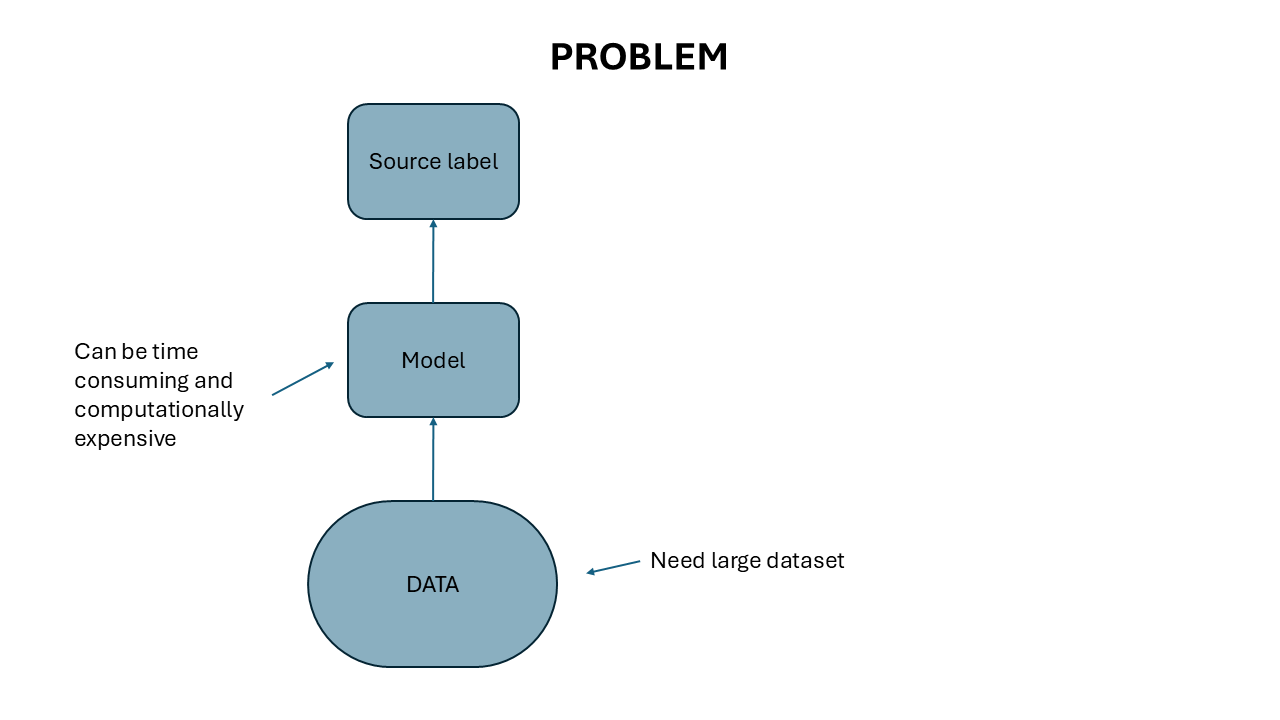

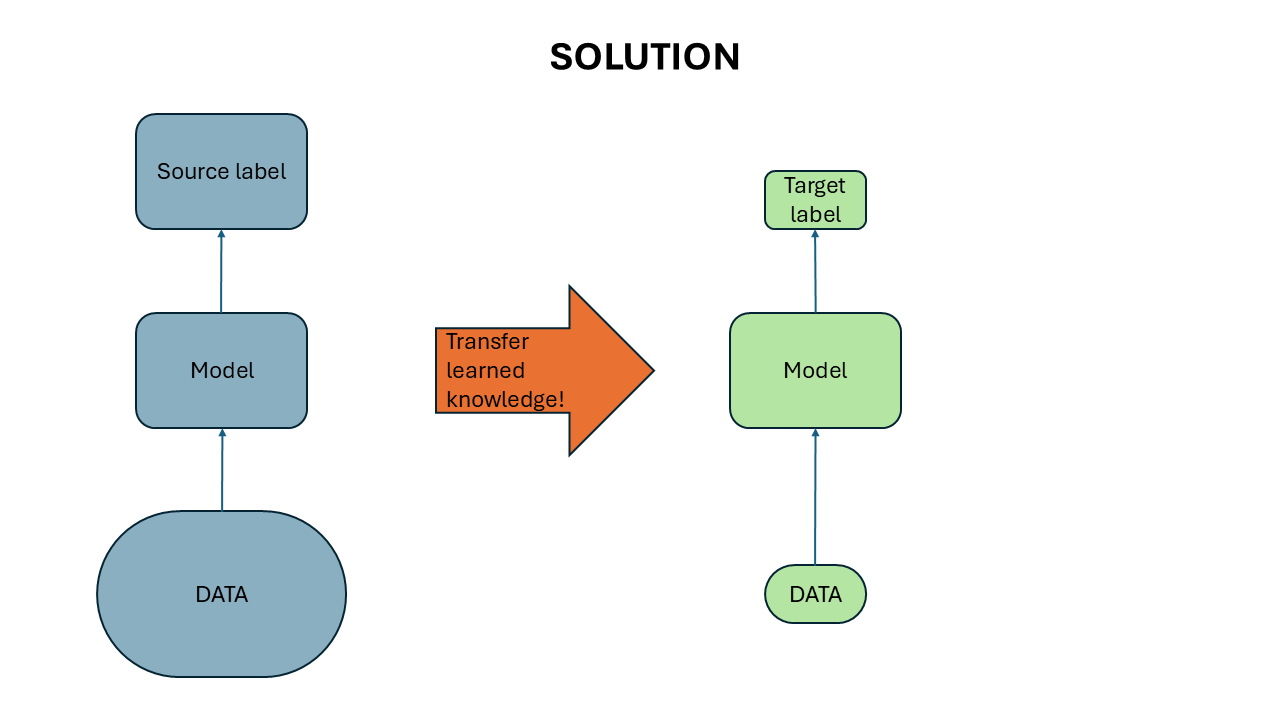

**Why use Transfer Learning:**

*   Data scarcity
*   Training times
*   Computation cost
*   Overfitting



**How Transfer Learning helps:**

*   Pre trained feature extractors
*   Better weight initialization
*   Data efficiency
*   Helps generalizing rare patterns
*   Hyper parameter tuning



## Tasks and Domains similarity

Transfer learning works best when:
* Sufficient level of domain similarity
* Sufficient level of task similarity
* A comparable model can be applied to both tasks

Otherwise, risk of **negative transfer**:
Transfer learning can negatively affect model performance

Ongoing field of research:
* Stolte, Marieke, et al. **"Methods for quantifying dataset similarity: a review, taxonomy and comparison."** Statistic Surveys 18 (2024): 163-298.






### Domain Similarity

Domain $\mathcal{D} = \{X, P(X)\}$:
* a feature space $X$
* a marginal probability distribution $P(X)$

**High Domain Similarity:**
* Data distribution, characteristics, format, modality and/or context are similar between the source and target domains
* Easier because the knowledge learned in one domain can be directly applied to the other

**Low Domain Similarity:**
* Datasets are dissimilar
* More challenging because differences must be addressed. Requires **cross-domain Transfer**

### Task Similarity
Task $\mathcal{T} = \{Y, f(X)\}$:
* a label space $Y$
* a predictive function $f:X \rightarrow Y$

**High Task Similarity:**  
* Tasks objectives and desired outputs are **closely related**

**Low Task Similarity:**  
*  The two tasks have **distinct objectives**


### Fine-tuning
|   |High task similarity | Low task similarity|
|---|---|---|
|**High domain similarity** |  **Fine-tuning** |  Inductive |
|**Low  domain similarity** |  Transductive | Unsupervised  |

**Characteristics**: large general source dataset, small specific labeled target dataset

**Example**:
* Source task: image classification
* Target task: dog breeds classification

**Goal**: specialize a generalized model for a specific, related problem

**Risks and mitigation**:
* Catastrophic forgetting
  * Freeze initial layers
  * Mix a small portion of the pre-training data during fine-tuning
* Overfitting the target data
  * Regularization (dropout, early stopping...)
  * Data augmentation
* Distribution shifts: loose some of the abilities gained in pre-training
  * Interpolate the weights of the source and target models
  * Modify only a small number of added parameters (PEFT)

**Is it transfer learning?**
* Further training of a pre-trained model on a new (task specific) dataset to improve its performance on a specific task. Can be applied to:
  * the entire neural network (= training from pre-trained weights)
  * only a subset (extra) model parameters
* By contrast, transfer learning signifies when users adapt a model to a new, related problem as opposed to the same problem.



### Transductive transfer learning *aka* Domain adaptation

|   |High task similarity | Low task similarity|
|---|---|---|
|**High domain similarity** |  Fine-tuning |  Inductive |
|**Low  domain similarity** |  **Transductive** | Unsupervised  |


**Characteristics**: Labeled source data, unlabeled target data

**Example**:
* Task: sentiment analysis
* Source model: trained on labeled restaurant reviews
* Target model: classify unlabeled movie reviews

**Goal**: bridge the "domain gap" so the source model performs well on the target domain

**Risks and mitigation**:
* Negative transfer:
  * Use similiarity metrics to decide whether to use transfer learning
  * Use MMD to learn features that are domain-agnostic
* Domain shift issues:
  * Assign weights to source data instances to match the target domain distribution
  * Use the target unlabelled data to adapt the model's decision boundary



### Inductive transfer learning
|   |High task similarity | Low task similarity|
|---|---|---|
|**High domain similarity** |  Fine-tuning |  **Inductive** |
|**Low  domain similarity** |  Transductive | Unsupervised  |

**Characteristics**: often the same domain but different data distribution/labels

**Example**:
* Source task: general image classification
* Target task: vehicle classification

**Goal**: transfer the "inductive bias" or general patterns learned from the source task to help the target task

**Risks and mitigation**:
* Irrelevant knowledge transfer
  * Identify and transfer only the relevant layers of the pre-trained model.
* Overfitting the source task:
  * Regularization (dropout, early stopping...)
  * Layer specific learning rates (higher for new layers)

### Unsupervised transfer learning
|   |High task similarity | Low task similarity|
|---|---|---|
|**High domain similarity** |  Fine-tuning |  Inductive |
|**Low  domain similarity** |  Transductive | **Unsupervised**  |

**Characteristics**: Similar to inductive, but:
* labeled data is unavailable in either source and target domains
* focuses on unsupervised tasks in both source and target domains

**Example**:
* Source task: clustering of transactions
* Target task: anomaly detection (fraud)

**Goal**: learn useful feature representations from unlabeled data

**Risks and mitigation**:
* Lack of guidance:
  * Create useful feature representation using self-supervised learning
* Domain variance:
  * Use methods that align the feature space across domains in an unsupervised manner
  * Use clustering techniques to identify common parterns between the two datasets



# Transfer Learning: Cats vs Dogs Classification with PyTorch


- Uses a model trained on a large, general dataset (like ImageNet).
- Applies the learned features to a new, smaller problem.
- Saves time and boosts accuracy for tasks with limited data.

**In this example:**
- Use a pretrained ResNet as a feature extractor
- Train a new classifier head to distinguish cats vs. dogs


In [ ]:
from IPython.display import Image, display

# This is a widely used ImageNet sample grid (hosted publicly, attribution: Stanford)
img_url = "https://paperswithcode.com/media/datasets/imagenet-sample.png"
display(Image(url=img_url))


100%|██████████| 170M/170M [00:03<00:00, 43.3MB/s]


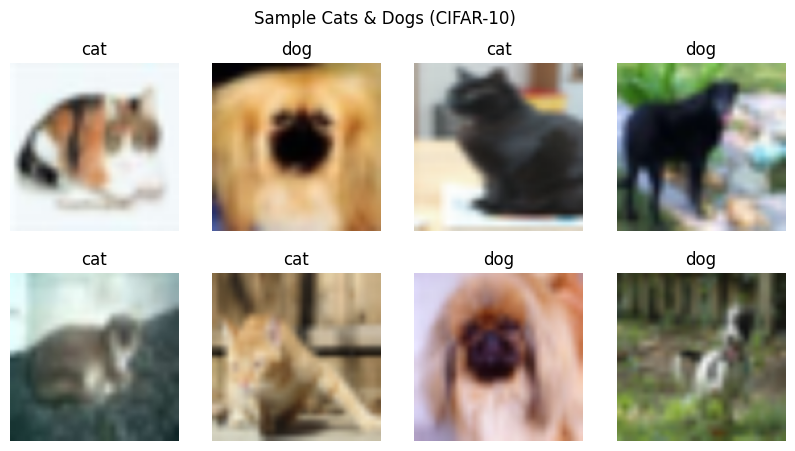

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time
import os

from torchvision import datasets, transforms

# Download CIFAR-10 dataset (contains 10 classes, including 'cat' and 'dog')
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

cifar_train = datasets.CIFAR10(root='.', train=True, download=True, transform=transform)
cifar_test = datasets.CIFAR10(root='.', train=False, download=True, transform=transform)

# Filter only cat (label 3) and dog (label 5)
cat_dog_idx_train = [i for i, label in enumerate(cifar_train.targets) if label in [3,5]]
cat_dog_idx_test = [i for i, label in enumerate(cifar_test.targets) if label in [3,5]]

class CatDogDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, idx):
        img, label = self.dataset[self.indices[idx]]
        return img, 0 if label == 3 else 1  # 0:cat, 1:dog

trainset = CatDogDataset(cifar_train, cat_dog_idx_train)
testset = CatDogDataset(cifar_test, cat_dog_idx_test)

# Visualize some samples
labels_map = {0: "cat", 1: "dog"}
fig, axs = plt.subplots(2, 4, figsize=(10, 5))
for i in range(8):
    img, label = trainset[np.random.randint(len(trainset))]
    ax = axs[i//4][i%4]
    ax.imshow(np.transpose(img.numpy(), (1,2,0)))
    ax.set_title(labels_map[label])
    ax.axis('off')
plt.suptitle("Sample Cats & Dogs (CIFAR-10)")
plt.show()




To improve generalization, we’ll apply random transformations (augmentation) during training.
- Random flips and crops create more diverse inputs.
- Dataloaders will efficiently batch and shuffle our data during training and evaluation.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from torch.utils.data import DataLoader, random_split

# Define augmentations for training, and simple transforms for test/val
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Remake datasets with transforms
trainset_aug = CatDogDataset(
    datasets.CIFAR10(root='.', train=True, download=True, transform=train_transform), cat_dog_idx_train
)
testset_aug = CatDogDataset(
    datasets.CIFAR10(root='.', train=False, download=True, transform=test_transform), cat_dog_idx_test
)

# Optionally split training set into train/val
train_size = int(0.8 * len(trainset_aug))
val_size = len(trainset_aug) - train_size
train_subset, val_subset = random_split(trainset_aug, [train_size, val_size])

batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(testset_aug, batch_size=batch_size, shuffle=False)

print("Number of training samples:", len(train_subset))
print("Number of validation samples:", len(val_subset))
print("Number of test samples:", len(testset_aug))


Number of training samples: 8000
Number of validation samples: 2000
Number of test samples: 2000


## Model Architecture: Transfer Learning

- We'll use a pretrained **ResNet18**—a deep convolutional network trained on ImageNet.
- The **early layers** recognize basic patterns (edges, textures)—useful for most images.
- We'll **replace the final layer** with a new classifier for ONLY cats (0) and dogs (1).
- We'll **freeze** the feature extractor (no gradient updates) and train the new classifier head.

## **BaseLine**

In [ ]:
from torchvision import models

# Load pretrained ResNet18 with its original classifier
model_baseline = models.resnet18(pretrained=True)
model_baseline.eval()
model_baseline = model_baseline.to(device)

# Define ImageNet index ranges for cats and dogs (approximate mapping)
cat_indices = set(range(281, 287))  # tabby, tiger, Persian, Siamese, Egyptian, Maine Coon
dog_indices = set(range(151, 269))  # includes 117 breeds of dog

# Baseline predictions
correct = 0
total = 0

from torchvision import transforms

# The model expects normalized [0,1] images with ImageNet mean/std
imagenet_preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

model_baseline.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = torch.stack([imagenet_preprocess(transforms.ToPILImage()(img)) for img in images.cpu()])
        images, labels = images.to(device), labels.to(device)
        outputs = model_baseline(images)
        _, preds = torch.max(outputs, 1)
        for pred, label in zip(preds.cpu().numpy(), labels.cpu().numpy()):
            if label == 0 and pred in cat_indices:  # True label cat
                correct += 1
            elif label == 1 and pred in dog_indices:  # True label dog
                correct += 1
            total += 1

print(f"Baseline ResNet18 accuracy (no transfer learning): {correct / total:.4f}")



/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 178MB/s]


Baseline ResNet18 accuracy (no transfer learning): 0.3825


In [ ]:
print("Incorrect identifications:", total - correct)

Incorrect identifications: 1235


## Second Baseline: ResNet-18 Without Pretrained Weights

To truly benchmark transfer learning, let’s see how a randomly initialized ResNet-18 performs on the new task:
- **No pretrained weights** (ImageNet knowledge not used).


In [ ]:
from torchvision import models

# Initialize ResNet18 (random weights)
model_scratch = models.resnet18(pretrained=False)
num_ftrs = model_scratch.fc.in_features
model_scratch.fc = nn.Linear(num_ftrs, 2)  # Cats vs dogs
model_scratch = model_scratch.to(device)

# Define loss and optimizer for all parameters
criterion = nn.CrossEntropyLoss()
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.01, momentum=0.9)
num_epochs_scratch = 5  # Feel free to increase, but training from scratch often needs more epochs

train_losses_s, val_losses_s, train_accs_s, val_accs_s = [], [], [], []

for epoch in range(num_epochs_scratch):
    # Training
    model_scratch.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_scratch.zero_grad()
        outputs = model_scratch(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_scratch.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    train_losses_s.append(running_loss / total)
    train_accs_s.append(correct / total)

    # Validation
    model_scratch.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_scratch(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    val_losses_s.append(val_loss / val_total)
    val_accs_s.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{num_epochs_scratch}: Train Loss {train_losses_s[-1]:.4f}, "
          f"Val Loss {val_losses_s[-1]:.4f}, Train Acc {train_accs_s[-1]:.4f}, Val Acc {val_accs_s[-1]:.4f}")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/5: Train Loss 0.8071, Val Loss 0.6286, Train Acc 0.5550, Val Acc 0.6535
Epoch 2/5: Train Loss 0.6647, Val Loss 0.6195, Train Acc 0.6256, Val Acc 0.6775
Epoch 3/5: Train Loss 0.6561, Val Loss 0.8243, Train Acc 0.6429, Val Acc 0.5440
Epoch 4/5: Train Loss 0.5928, Val Loss 0.5452, Train Acc 0.6914, Val Acc 0.7300
Epoch 5/5: Train Loss 0.5640, Val Loss 0.5784, Train Acc 0.7040, Val Acc 0.7000


Test accuracy (model_scratch): 0.6965


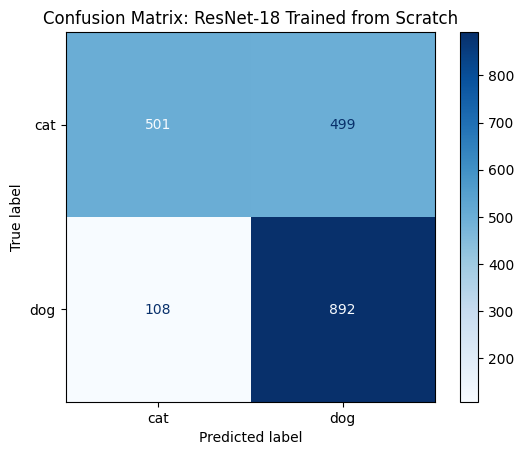

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Collect predictions and targets across the test set
scratch_preds = []
scratch_targets = []

model_scratch.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_scratch(images)
        _, preds = torch.max(outputs, 1)
        scratch_preds.extend(preds.cpu().numpy())
        scratch_targets.extend(labels.cpu().numpy())

# Compute test accuracy
acc_scratch = accuracy_score(scratch_targets, scratch_preds)
print(f"Test accuracy (model_scratch): {acc_scratch:.4f}")

# Plot confusion matrix
cm_scratch = confusion_matrix(scratch_targets, scratch_preds)
disp_scratch = ConfusionMatrixDisplay(confusion_matrix=cm_scratch, display_labels=["cat", "dog"])
disp_scratch.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix: ResNet-18 Trained from Scratch')
plt.show()


In [ ]:
scratch_preds = []
scratch_targets = []

model_scratch.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_scratch(images)
        _, preds = torch.max(outputs, 1)
        scratch_preds.extend(preds.cpu().numpy())
        scratch_targets.extend(labels.cpu().numpy())

scratch_preds = np.array(scratch_preds)
scratch_targets = np.array(scratch_targets)

total = len(scratch_targets)
correct = np.sum(scratch_preds == scratch_targets)
incorrect = total - correct

print(f"Total test images: {total}")
print(f"Correct predictions: {correct}")
print(f"Incorrect predictions: {incorrect}")
print(f"Accuracy: {correct / total :.4f}")

Total test images: 2000
Correct predictions: 1393
Incorrect predictions: 607
Accuracy: 0.6965


## Transfer learning using pretrained resnet 18

In [ ]:
from torchvision import models

# Load pretrained ResNet18
model = models.resnet18(pretrained=True)

# Freeze all layers except the classifier
for param in model.parameters():
    param.requires_grad = False

# Replace the fully connected layer for binary classification (cat vs dog)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes: cat, dog

model = model.to(device)

# Print model summary (optional, shows only unfrozen param count at the end)
print(model)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 190MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
num_epochs = 5

train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    train_losses.append(running_loss / total)
    train_accs.append(correct / total)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    val_losses.append(val_loss / val_total)
    val_accs.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss {train_losses[-1]:.4f}, "
          f"Val Loss {val_losses[-1]:.4f}, Train Acc {train_accs[-1]:.4f}, Val Acc {val_accs[-1]:.4f}")


Epoch 1/5: Train Loss 0.5117, Val Loss 0.4430, Train Acc 0.7445, Val Acc 0.7785
Epoch 2/5: Train Loss 0.4508, Val Loss 0.4548, Train Acc 0.7903, Val Acc 0.7740
Epoch 3/5: Train Loss 0.4380, Val Loss 0.4407, Train Acc 0.7919, Val Acc 0.7885
Epoch 4/5: Train Loss 0.4417, Val Loss 0.4369, Train Acc 0.7901, Val Acc 0.7950
Epoch 5/5: Train Loss 0.4324, Val Loss 0.4367, Train Acc 0.7976, Val Acc 0.7980


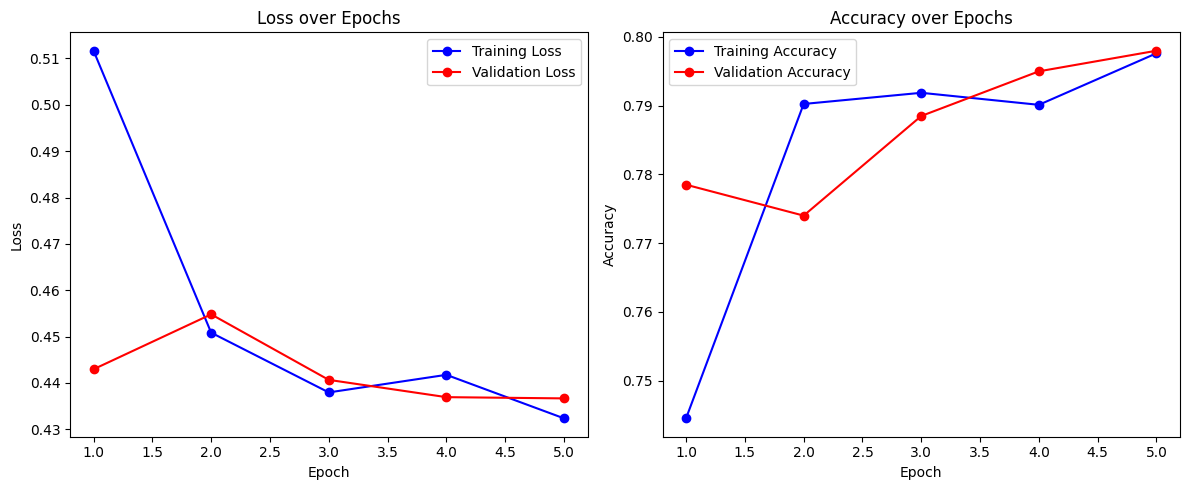

In [ ]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accs, 'ro-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


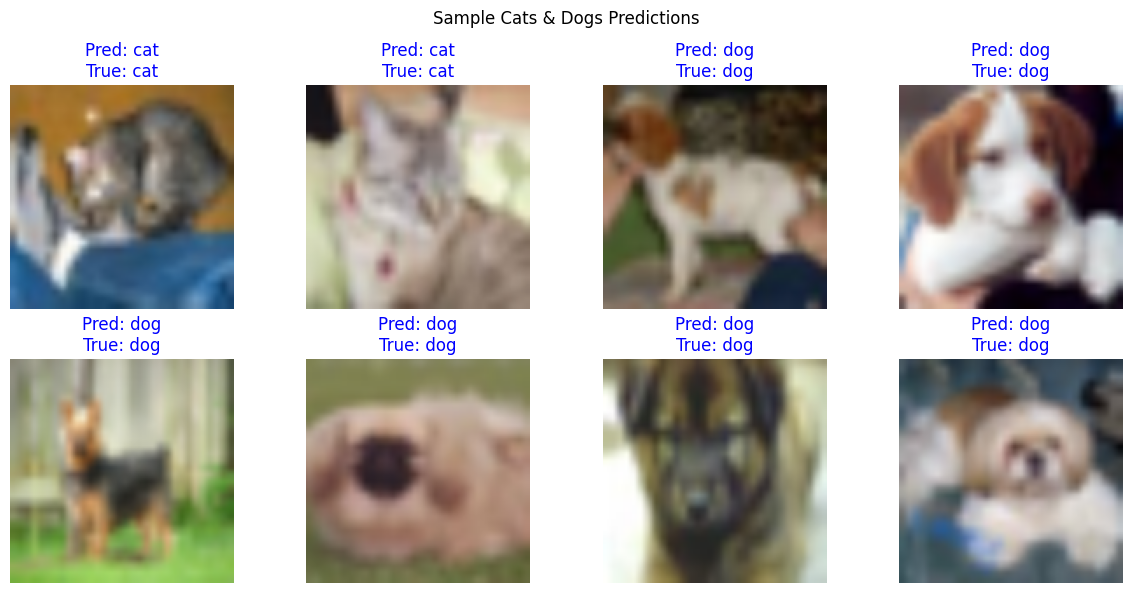

In [ ]:
labels_map = {0: "cat", 1: "dog"}

# Get a batch of test images and their labels
model.eval()
images, true_labels = next(iter(test_loader))
images, true_labels = images.to(device), true_labels.to(device)

# Get model predictions
with torch.no_grad():
    outputs = model(images)
    _, pred_labels = torch.max(outputs, 1)

# Move to CPU for visualization
images = images.cpu()
true_labels = true_labels.cpu()
pred_labels = pred_labels.cpu()

plt.figure(figsize=(12,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    img = images[i].numpy()
    plt.imshow(np.transpose(img, (1,2,0)))
    # Title colored: blue if correct, red if incorrect
    color = 'blue' if pred_labels[i] == true_labels[i] else 'red'
    plt.title(f"Pred: {labels_map[pred_labels[i].item()]}\nTrue: {labels_map[true_labels[i].item()]}", color=color)
    plt.axis('off')
plt.suptitle("Sample Cats & Dogs Predictions")
plt.tight_layout()
plt.show()


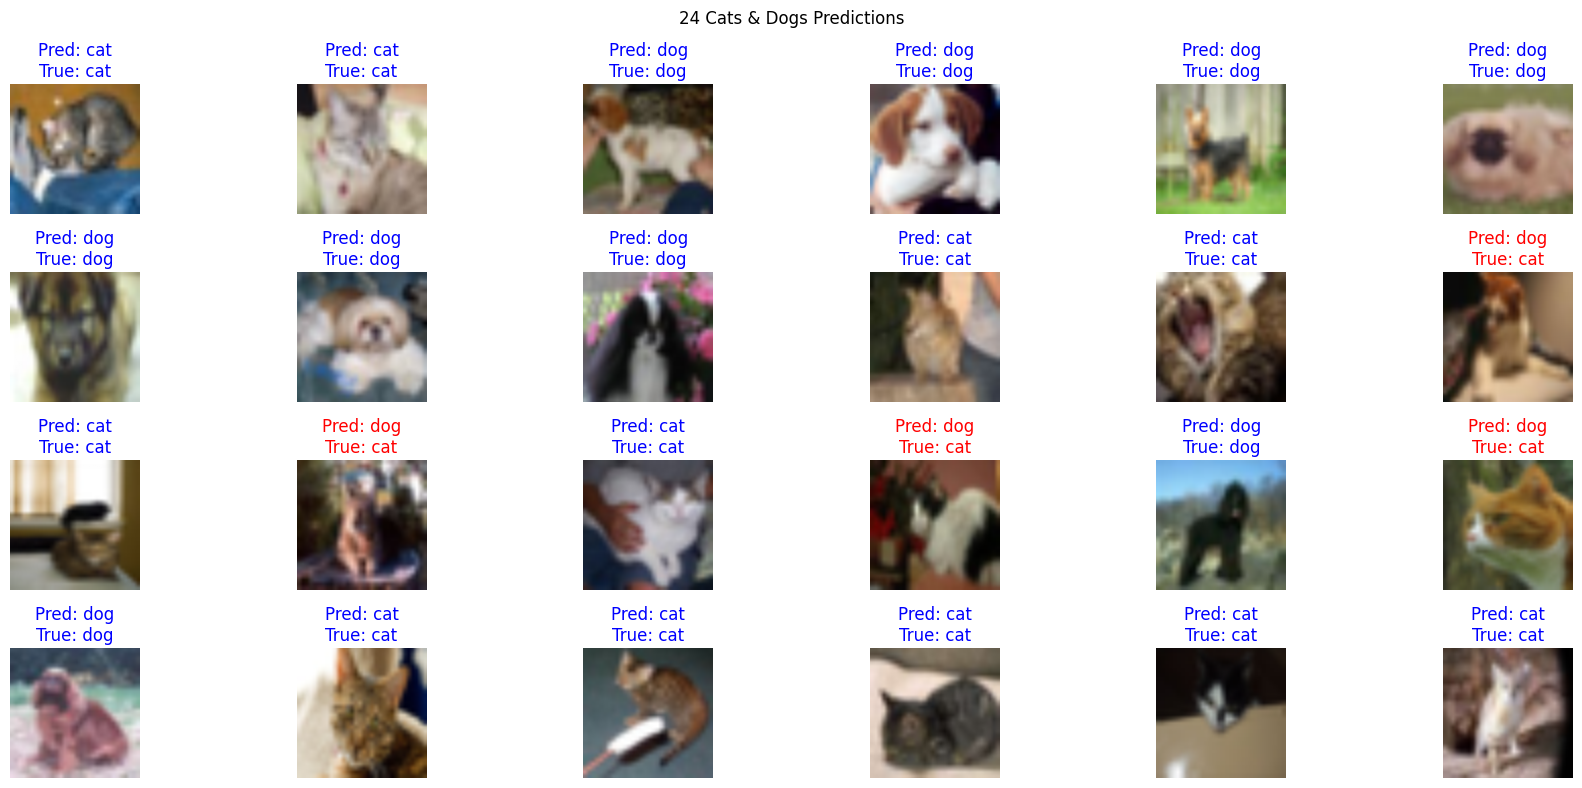

In [ ]:
num_images = 24  # Change this number as needed (grid will auto-size)
rows = num_images // 6 if num_images >= 12 else 2
cols = 6 if num_images >= 12 else min(num_images, 8)

# Gather enough images/predictions
images, true_labels = next(iter(test_loader))
images, true_labels = images[:num_images].to(device), true_labels[:num_images].to(device)

outputs = model(images)
_, pred_labels = torch.max(outputs, 1)

images = images.cpu()
pred_labels = pred_labels.cpu()
true_labels = true_labels.cpu()

plt.figure(figsize=(3 * cols, 2 * rows))
for i in range(num_images):
    plt.subplot(rows, cols, i+1)
    img = images[i].numpy()
    plt.imshow(np.transpose(img, (1,2,0)))
    color = 'blue' if pred_labels[i] == true_labels[i] else 'red'
    plt.title(f"Pred: {labels_map[pred_labels[i].item()]}\nTrue: {labels_map[true_labels[i].item()]}", color=color)
    plt.axis('off')
plt.suptitle(f"{num_images} Cats & Dogs Predictions")
plt.tight_layout()
plt.show()


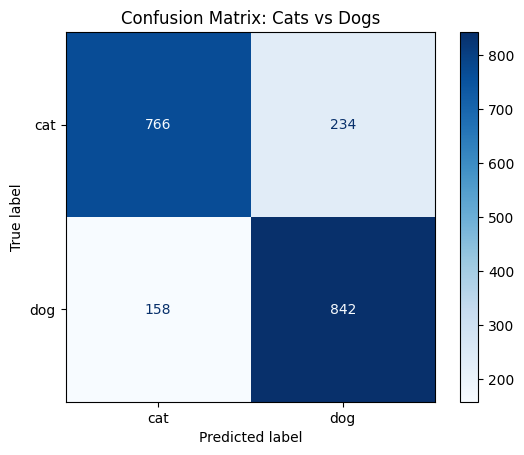

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["cat", "dog"])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix: Cats vs Dogs')
plt.show()


Found 392 misclassified images in the test set.


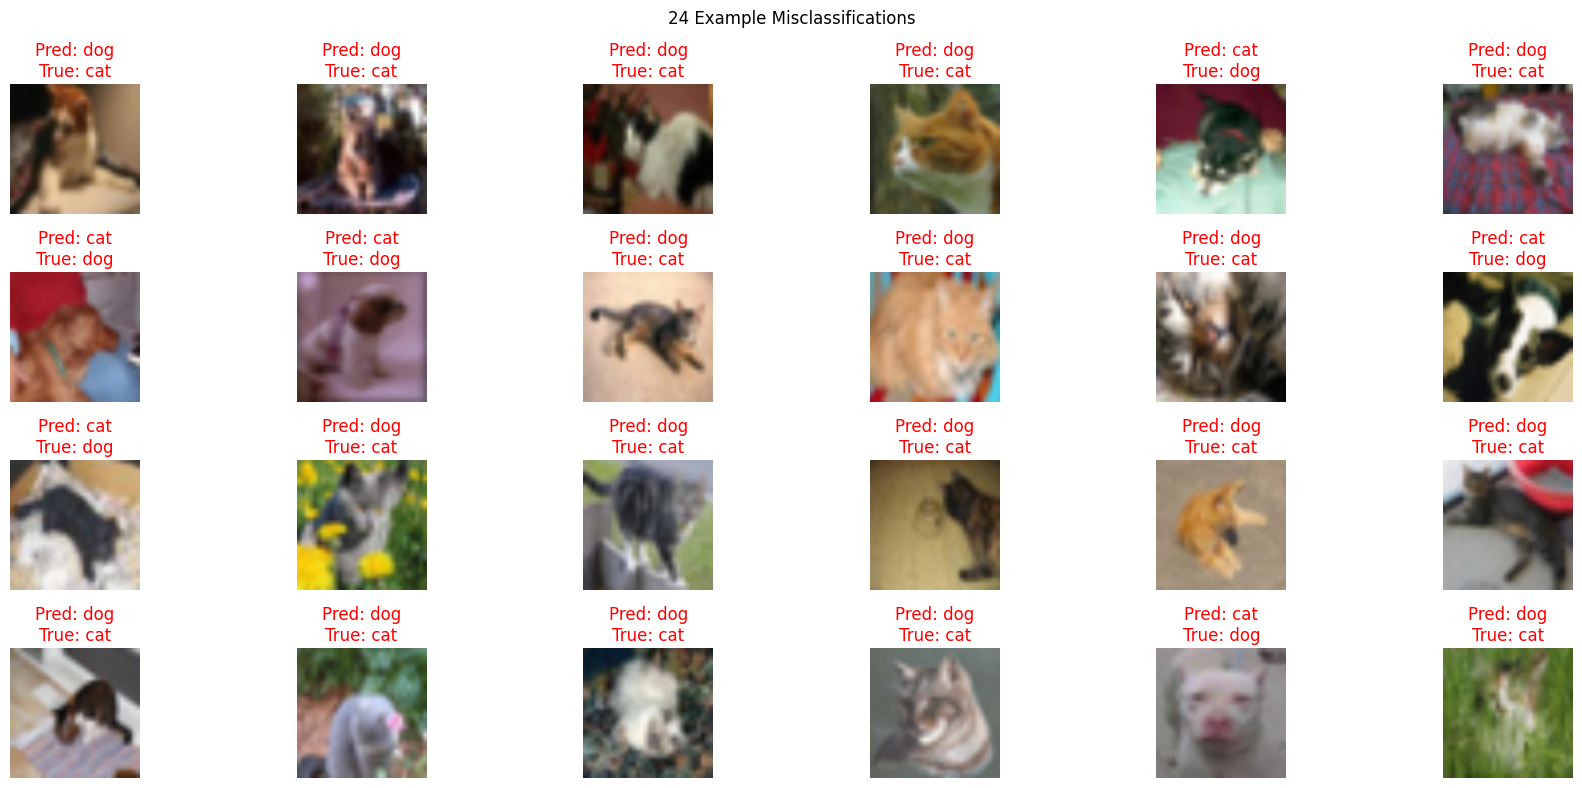

In [ ]:
# Collect all errors (misclassifications)
error_images = []
error_true = []
error_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        # Find indices where prediction != ground truth
        for i in range(images.size(0)):
            if preds[i] != labels[i]:
                error_images.append(images[i].cpu())
                error_true.append(labels[i].cpu().item())
                error_pred.append(preds[i].cpu().item())

print(f"Found {len(error_images)} misclassified images in the test set.")

# Plot up to 24 errors for visualization
num_errors_to_plot = min(len(error_images), 24)
rows = num_errors_to_plot // 6 if num_errors_to_plot >= 12 else 2
cols = 6 if num_errors_to_plot >= 12 else min(num_errors_to_plot, 8)

plt.figure(figsize=(3*cols, 2*rows))
for i in range(num_errors_to_plot):
    plt.subplot(rows, cols, i + 1)
    img = error_images[i].numpy()
    plt.imshow(np.transpose(img, (1,2,0)))
    true_label = labels_map[error_true[i]]
    pred_label = labels_map[error_pred[i]]
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color="red")
    plt.axis("off")
plt.suptitle(f"{num_errors_to_plot} Example Misclassifications")
plt.tight_layout()
plt.show()


##  Fine-Tuning: Training All Layers

Instead of just training the final classifier, we can “unfreeze” all layers and continue training.
- Model adapts its early features to the cats vs dogs data.
- Often improves performance, especially when more data is available.
- Use a **smaller learning rate**, as the weights are already good.


In [ ]:
# Unfreeze all model parameters for training
for param in model.parameters():
    param.requires_grad = True

# Use a smaller learning rate for fine-tuning
optimizer_ft = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

num_ft_epochs = 5  # You can increase this for more fine-tuning

finetune_losses, finetune_accs = [], []

for epoch in range(num_ft_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_ft.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_ft.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    finetune_losses.append(running_loss / total)
    finetune_accs.append(correct / total)
    print(f"Fine-tune Epoch {epoch+1}/{num_ft_epochs}: Loss {finetune_losses[-1]:.4f}, Acc {finetune_accs[-1]:.4f}")


Fine-tune Epoch 1/5: Loss 0.2757, Acc 0.8779
Fine-tune Epoch 2/5: Loss 0.2636, Acc 0.8888
Fine-tune Epoch 3/5: Loss 0.2472, Acc 0.8916
Fine-tune Epoch 4/5: Loss 0.2336, Acc 0.9025
Fine-tune Epoch 5/5: Loss 0.2175, Acc 0.9101


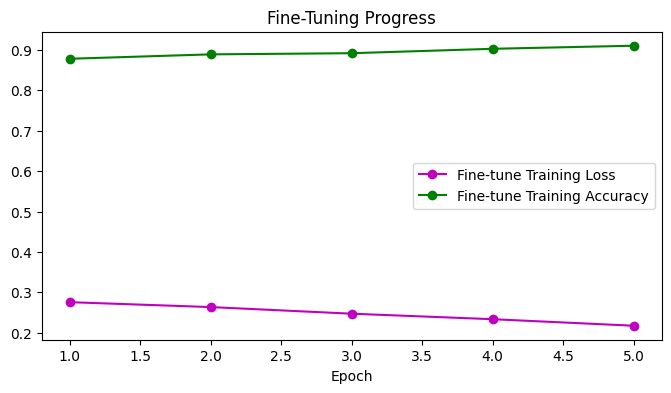

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(range(1, num_ft_epochs+1), finetune_losses, 'mo-', label='Fine-tune Training Loss')
plt.plot(range(1, num_ft_epochs+1), finetune_accs, 'go-', label='Fine-tune Training Accuracy')
plt.xlabel('Epoch')
plt.title('Fine-Tuning Progress')
plt.legend()
plt.show()


Test accuracy after fine-tuning: 0.8975


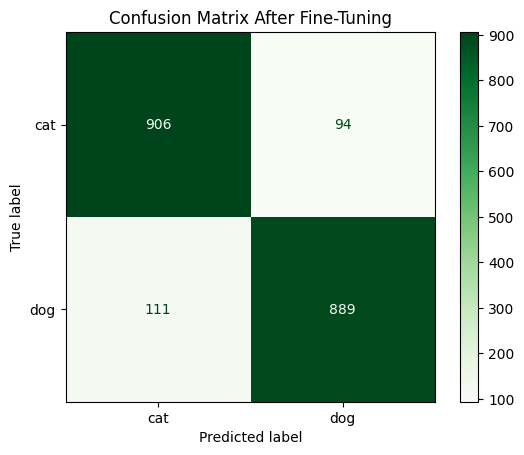

In [ ]:
# Re-calculate accuracy and gather predictions/targets
finetune_preds = []
finetune_targets = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        finetune_preds.extend(preds.cpu().numpy())
        finetune_targets.extend(labels.cpu().numpy())

# Compute accuracy
from sklearn.metrics import accuracy_score
ft_acc = accuracy_score(finetune_targets, finetune_preds)
print(f"Test accuracy after fine-tuning: {ft_acc:.4f}")

# Plot the new confusion matrix
cm_ft = confusion_matrix(finetune_targets, finetune_preds)
disp_ft = ConfusionMatrixDisplay(confusion_matrix=cm_ft, display_labels=["cat", "dog"])
disp_ft.plot(cmap=plt.cm.Greens)
plt.title('Confusion Matrix After Fine-Tuning')
plt.show()


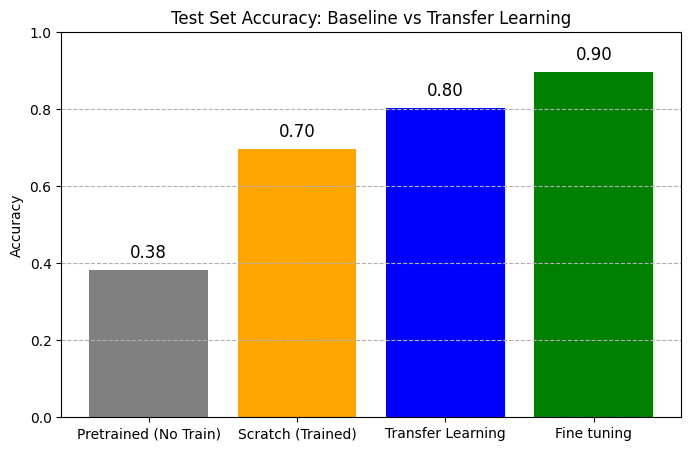

In [10]:
# Example accuracy variables (fill in these with your actual results)

acc_pretrained = 0.3825  # Pretrained weights, no train
acc_scratch = 0.6965    # Random weights, trained
acc_transfer = 1-(392/2000)   # Transfer learning/fine-tuned
acc_finetune = 0.8975    # Fine-tuning all layers
# Collect accuracies in list
label_names = ["Pretrained (No Train)", "Scratch (Trained)",
               "Transfer Learning", "Fine tuning"]
acc_values = [acc_pretrained, acc_scratch, acc_transfer, acc_finetune]

plt.figure(figsize=(8,5))
bars = plt.bar(label_names, acc_values, color=["gray", "orange", "blue", "green"])
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Test Set Accuracy: Baseline vs Transfer Learning")
plt.grid(axis="y", linestyle="--")

# Annotate values
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+0.02, f"{bar.get_height():.2f}",
             ha='center', va='bottom', fontsize=12)
plt.show()


- Above results for training all networks only for 5 epochs for the sake of example
- Transfer learning lets us get **good performance with limited data**.
- Pretrained CNNs learn generic features (edges, textures, shapes) that transfer well.
- **Freezing + new head** is fast and often sufficient for simple tasks.
- **Fine-tuning** all layers can further improve performance, especially with more data.

References:

https://medium.com/@davidfagb/guide-to-transfer-learning-in-deep-learning-1f685db1fc94

https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a/



